In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2 as cv
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [2]:
path = 'C:/Users/alcob/Desktop/BrainStation/Python/BrainStationCapstone/archive/'

folder_list = ['cadesp', 'lattes', 'nfe', 'nfesjppr', 'pje', 'rfb', 'rsc', 'sefazsp', 'sintegrarj', 'tjrs', 'trt3']

----
**Initial SetUp:**

Utility Functions and Classes:

We define CaptchaLibrary as an empty class that will hold all our Captcha class objects.

The each Captcha class will contain the images and targets that we will use for training and testing.

In [3]:
class CaptchaLibrary:
    pass

class Captcha:
    def __init__(self, image_list, target_list):
        self.images = image_list
        self.targets = target_list

def GetImages(folder_path, limit = 0):
    """""""""
    This function will return a list containing the first pictures up to a certain 'limit', from the specified folder path.
    If the limit is 0 it will append all pictures from the folder. 
    """""""""
    count = 0
    
    image_list = []
    
    for filename in glob.glob(path + folder_path + '/*.*'):
        image=cv.imread(filename)
        image_list.append(image)
        
        if limit > 0:
            count += 1
            if count >= limit:
                break
    
    return image_list

def GetTargets(folder_path, limit):
    """""""""
    This function will return a list containing the first filenames (i.e the targets) up to a certain 'limit', from the specified folder path.
    If limit is 0 it will append all the filenames from the folder.
    """""""""
    
    count = 0
    
    target_list = []
    
    for filename in glob.glob(path + folder_path + '/*.*'):
        target_list.append(filename)
        
        if limit > 0:
            count += 1
            if count >= limit:
                break
    
    target_list = list(map(lambda x: x.split('\\')[1].split('.')[0], target_list))
    
    return target_list

Here we will dynamically create 'Captcha' variables by looping through the folders in the list above.

In [4]:
library = CaptchaLibrary()

for folder  in folder_list:
    captchas = GetImages(folder, 0)
    targets = GetTargets(folder, 0)
    setattr(library, folder, Captcha(captchas, targets))

<Figure size 432x288 with 0 Axes>

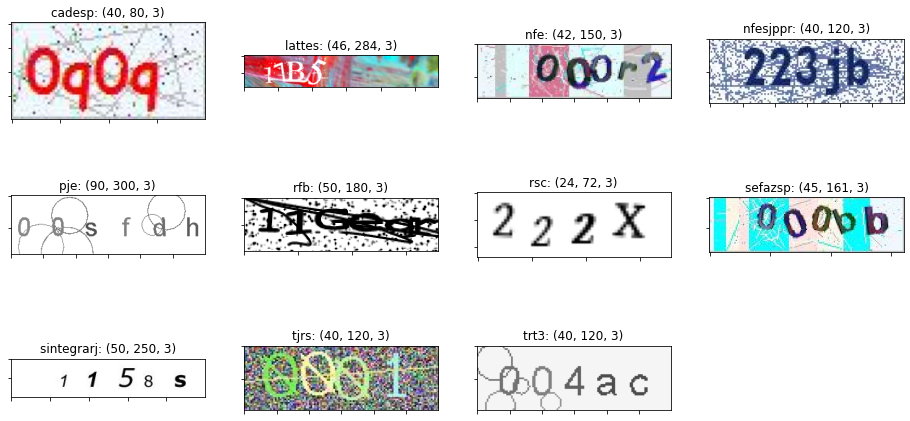

In [5]:
plt.figure()

fig, axes = plt.subplots(3, 4, figsize = (16, 8))

library_variables = [library.cadesp, library.lattes, library.nfe,
                    library.nfesjppr, library.pje, library.rfb, library.rsc,
                    library.sefazsp, library.sintegrarj, library.tjrs, library.trt3]

for i, lib in enumerate(library_variables):

    plt.subplot(3, 4, i + 1)
    
    example_image = lib.images[0]
    
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.title(f'{folder_list[i]}: {np.asarray(example_image).shape}')
    plt.tick_params(labelleft = False, labelbottom = False)

fig.delaxes(axes.flatten()[11])

plt.show()

------
**Image Preprocessing**

Before we test out any initial models, it is important that we first clean up the images by following some of the steps we will show here:

This Image has Dimensions: (40, 120, 3).


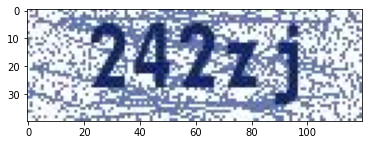

In [6]:
image = library.nfesjppr.images[42]
image_copy = image.copy()

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
print(f'This Image has Dimensions: {image.shape}.')

As we can see this Captcha is an image in RGB format. As color will not play such an important role in determining each character we will start by changing the image to grayscale. This will also have the benefit of decreasing our run time by reducing the number of dimensions.

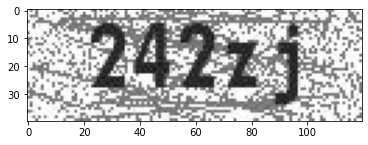

In [7]:
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #Change Image to Grayscale

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

Some images use random noise, dots and segments to trick automated bots, something we can do to reduce this is apply some blur to the image and apply some thresholding.

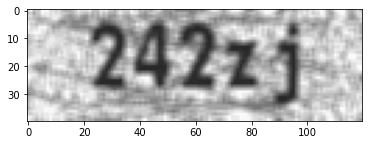

In [8]:
image = cv.blur(image, (3,3))

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

With thresholding we can separate background from character. This is generally how we want an image to look before our final steps.

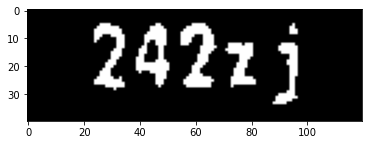

In [9]:
_ , image = cv.threshold(image, 100, 255, cv.THRESH_BINARY_INV)

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

Finally we will use use cv2's findContours and boundingRect functions to get the contours of each character and 'draw' the smallest box around each contour.

In [10]:
contours, hier = cv.findContours(image, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

contours_poly = list(range(len(contours)))

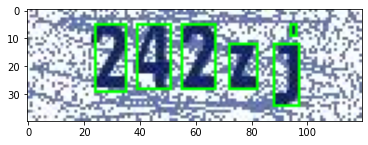

In [11]:
boundRect = []

for i, c in enumerate(contours):

    if hier[0][i][3] == -1:
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect.append(cv.boundingRect(contours_poly[i]))

# For Visualization
for i in range(len(boundRect)):
    color = (0, 255, 0)
    cv.rectangle(image_copy, (int(boundRect[i][0]), int(boundRect[i][1])), 
              (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 1)
    
plt.imshow(cv.cvtColor(image_copy, cv.COLOR_BGR2RGB))

Other techniques we can use are dilation to eliminate any thin obstructions in a CAPTCHA.

This Image has Dimensions: (40, 120).


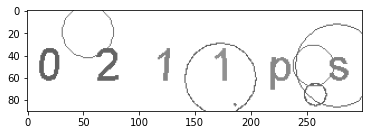

In [12]:
image_to_dilate = library.pje.images[4]

#We use 2x2 because we only want to remove the thinnest segments,
#anything higher or a higher number ot iterations and we risk erasing a character.
kernel = np.ones((2,2),np.uint8)

dilated_image =cv.dilate(image_to_dilate ,kernel ,iterations=2)

plt.imshow(cv.cvtColor(image_to_dilate, cv.COLOR_BGR2RGB))

print(f'This Image has Dimensions: {image.shape}.')

This Image has Dimensions: (40, 120).


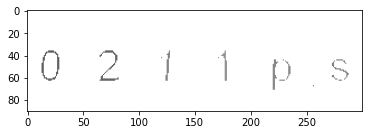

In [13]:
plt.imshow(cv.cvtColor(dilated_image, cv.COLOR_BGR2RGB))

print(f'This Image has Dimensions: {image.shape}.')

Additionally the following functions will be used on cases where two characters overlap, and to account for the disjointed dot over i's and j's.

In [14]:
def SeparateOverlappingLetters(bounds):
    """""""""
    This function's input is a list of rectangle bounds, it will split the same bounds with the largest one split in half.
    """""""""
    
    #Each bound is defined a list with [X, Y, width, height] elements, we sort by height so the bound with the largest lenght.
    bounds.sort(key = lambda x:x[2], reverse = True)

    halved_height = int(bounds[0][2]/2)
    
    # Here we set the width of the largest box to be half of its original size
    bounds[0] = bounds[0][:2] + (halved_height,) + bounds[0][3:] 
    
    rect2_new_xcoordinate = int(bounds[0][0] + halved_height)
    
    # We make a new box, same dimensions as the first but with a new x-coordinate
    new_rect = bounds[0]
    
    new_rect = (rect2_new_xcoordinate,) + bounds[0][1:]
    
    bounds.append(new_rect)

    bounds.sort(key = lambda x:x[0]) # Sorts so they are in the correct sequence
    
    return bounds 

In [15]:
def JoinDisconnectedLetter(bounds):
    """""""""
    This function's input is a list of rectangle bounds, it will join the two boxes based on the shortest x-proximity.
    """""""""
    bounds.sort()
    
    minDiff = np.Infinity
    
    #We find the two boxes that are the closest to each other in terms of their x -coordinate
    for i in range(1, len(bounds)):
        minDiff = min(minDiff, np.abs(bounds[i][0] - bounds[i-1][0]))
        
    for j in range(1, len(bounds)):
        if (bounds[j][0] - bounds[j-1][0]) <= minDiff:
            closest_rect = [bounds[j],bounds[j-1]]
    
    #We will remove the original boxes and append a new larger one.
    for k in closest_rect:
        bounds.remove(k)
    
    newRect = (min(closest_rect[0][0],closest_rect[1][0]),
               min(closest_rect[0][1],closest_rect[1][1]),
               max(closest_rect[0][2],closest_rect[1][2]),
               closest_rect[0][3] + closest_rect[1][3])
    
    bounds.append(newRect)
    
    bounds.sort(key = lambda x:x[0]) # Sorts so they are in the correct sequence
        
    return bounds

We define a function that applies all the transformations, and another to crop and separate each character:

In [16]:
def TransformImage(image, THRESHOLD = 150, APPLY_BLUR = False, APPLY_DILATION = False):
    """""""""
    This function takes as input an image, it will apply the following tranformations to it:
    
    Change Mode to Grayscale -> Blur (if True) -> Dilate (if True) -> Threshold with specified value
    
    It will also return the list of bounding rectangles of each character.
    """""""""
    #Initial Transforms
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #Set to Grayscale
    
    if APPLY_BLUR == True:
        image = cv.blur(image, (3,3))
    
    if APPLY_DILATION == True:
        kernel = np.ones((2,2),np.uint8)
        image =cv.dilate(image ,kernel,iterations = 1)
    
    _ , image = cv.threshold(image, THRESHOLD, 255, cv.THRESH_BINARY_INV) #Apply Thresholding
    
    #Finding Contours of each Character
    contours, hier = cv.findContours(image, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    
    contours_poly = list(range(len(contours)))
    
    #Get Bounding Rectangles
    boundRect = []
    
    for i, c in enumerate(contours):
        if hier[0][i][3] == -1:
            contours_poly[i] = cv.approxPolyDP(c, 3, True)
            boundRect.append(cv.boundingRect(contours_poly[i]))
            
    boundRect.sort(key = lambda x:x[0]) # Sorts so they are in the correct sequence
    
    return (image, boundRect)

In [17]:
def SplitImage(image, bounds):    
    """""""""
    Takes an image and rectangle bounds as input. It will then crop the image by using each character's
    corresponding bounds and return them in a list.
    """""""""
    cropped_image_list = []
    for i in range(len(bounds)):
        x, y, w, h = bounds[i]
    
        cropped_image = image[y:y + h, x:x + w]
        cropped_image_list.append(cropped_image)

    return cropped_image_list

In [18]:
def LoadSample(image_list, label_list, X, y, THRESHOLD = 150, APPLY_BLUR = False, APPLY_DILATION = False):
    
    """""""""""
    It will apply the transformations on all the images in a list, split them into separate letter and append each
    letter and its label to X and y.
    
    It will also decide whether to apply the functions to Separate overlaps or combine disjoints if the number of labels does
    not match the number of cropped images in a captcha.
    """""""""""
    
    for i in range(len(image_list)):
        
        transformed_image, rect_bounds = TransformImage(image_list[i], THRESHOLD, APPLY_BLUR, APPLY_DILATION)
        
        target_seq = label_list[i]
        
        if len(rect_bounds) == len(target_seq):
            image_splits = SplitImage(transformed_image, rect_bounds)
            
            if len(image_splits) == (len(target_seq)):
                for j in range(len(image_splits)):
                    X.append(image_splits[j])
                    y.append(target_seq[j])
            else:
                print('Cannot Load :',  i)
                
        elif len(rect_bounds) < len(target_seq):
            while len(rect_bounds) < (len(target_seq)):
                rect_bounds = SeparateOverlappingLetters(rect_bounds)
                
            image_splits = SplitImage(transformed_image, rect_bounds)
            
            if len(image_splits) == (len(target_seq)):
                for k in range(len(image_splits)):
                    X.append(image_splits[k])
                    y.append(target_seq[k])
            else:
                print('Cannot Load :',  i)
        
        elif len(rect_bounds) > (len(target_seq)):
            while len(rect_bounds) > (len(target_seq)):
                rect_bounds = JoinDisconnectedLetter(rect_bounds)
                
            image_splits = SplitImage(transformed_image, rect_bounds)
            
            if len(image_splits) == (len(target_seq)):
                for k in range(len(image_splits)):
                    X.append(image_splits[k])
                    y.append(target_seq[k])
            else:
                print('Cannot Load :',  i)

Please note that these steps are not perfect and there are cases where findcontours detects other pixels that were not properly removed after we threshold (We will see this later on). These are some of the steps that work on some of the Captchas.

In [19]:
#library rsc        :: THRESHOLD=180 , APPLY_BLUR=False , APPLY_DILATION = False
#library nfesjppr   :: THRESHOLD=100 , APPLY_BLUR=True , APPLY_DILATION = False
#library sintegrarj :: THRESHOLD=180 , APPLY_BLUR=False , APPLY_DILATION = False
#library cadesp     :: THRESHOLD=120 , APPLY_BLUR=True , APPLY_DILATION = False
#library pje        :: THRESHOLD=160 , APPLY_BLUR=False , APPLY_DILATION = True
#library sefazsp    :: THRESHOLD=140 , APPLY_BLUR=True  , APPLY_DILATION = False

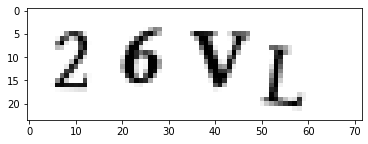

In [20]:
image = library.rsc.images[42]

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [21]:
library_test = library.rsc
threshold = 180
blur = False
dilate = False

X_sample = []
y_sample = []

img_train, img_test, lab_train, lab_test = train_test_split(library_test.images, library_test.targets, test_size = 0.3)

LoadSample(img_train, lab_train, X_sample, y_sample, THRESHOLD = threshold, APPLY_BLUR = blur, APPLY_DILATION = dilate)

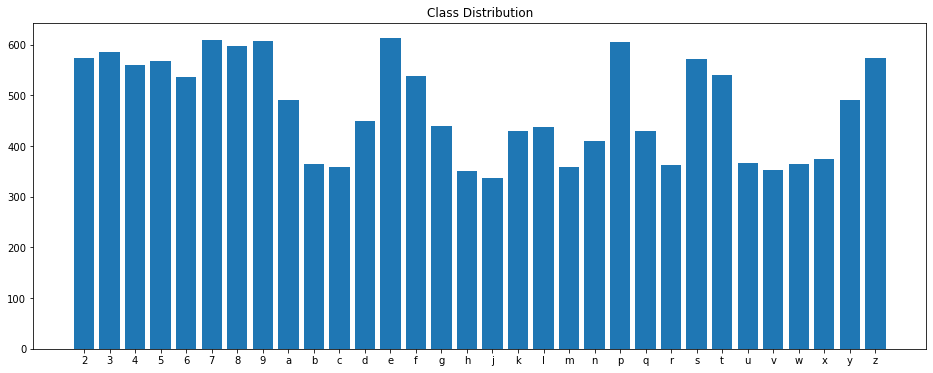

In [22]:
items, counts = np.unique(y_sample, return_counts = True)

plt.figure(figsize = (16, 6))

plt.bar(items, counts)
plt.title('Class Distribution')

plt.show()

In [23]:
if (len(X_sample) == len(y_sample)):
    print(f'We are ready to train the model! There are {len(X_sample)} total samples we can use to train on.')
else:
    print(f'Oops, something muct be wrong: the number of cropped letters does not match the number of labels.')
    print(f'X: {len(X_sample)}, y: {y_sample}')

We are ready to train the model! There are 15248 total samples we can use to train on.


Not all cropped letters are of the same dimensions after being cropped. So we will reshape them for the model.

In [24]:
def Reshape_Transform(image, dim = (12, 12)):
    
    """""""""
    Reshapes an image into a specified dimension.
    
    Because stretching might make some parts of a character lighter, we will apply threshold again.
    """""""""
    
    resized_image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
    
    resized_image = cv.bitwise_not(resized_image)
    
    _ , resized_image = cv.threshold(resized_image, 180, 255, cv.THRESH_BINARY_INV)
    
    return resized_image

In [25]:
for i in range(len(X_sample)):
    X_sample[i] = Reshape_Transform(X_sample[i], dim = (20, 20))

Sanity check:

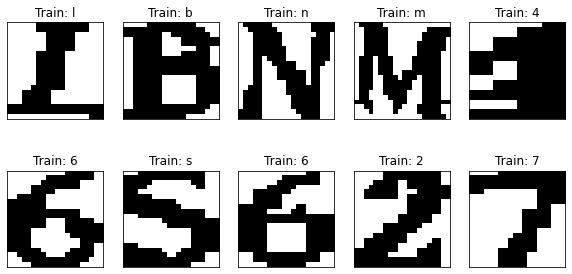

In [26]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))

plot_index = 0

for i in [random.randrange(len(X_sample)) for i in range(10)]:
    plot_index += 1
    plt.subplot(2, 5, plot_index)
    plt.imshow(X_sample[i], cmap="gray_r")
    plt.title(f'Train: {y_sample[i]}')
    
    plt.tick_params(left = False, labelleft = False,
                labelbottom = False, bottom = False)
    
plt.show()

We finish our preprocessing by flattening our image and scaling all the values so they are either 0 or 1:

In [27]:
X_sample = np.asarray(X_sample)

X_sample = X_sample.reshape(X_sample.shape[0], X_sample[0].shape[0] * X_sample[0].shape[1])

X_sample = X_sample/255

**Predicting Using Logistic Regression**

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size = 0.3, stratify = y_sample)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

C:\Users\alcob\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
train_prediction = logreg.predict(X_train)
val_prediction = logreg.predict(X_val)

train_accuracy = accuracy_score(train_prediction, y_train)
val_accuracy = accuracy_score(val_prediction, y_val)

print(f"Training set accuracy score: {train_accuracy}")
print(f"Val set accuracy score: {val_accuracy}")

Training set accuracy score: 1.0
Val set accuracy score: 0.9873224043715847


In [30]:
coefs = logreg.coef_.reshape(-1, 20, 20)

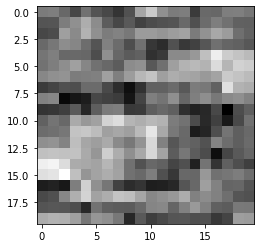

In [31]:
plt.imshow(coefs[3], cmap="gray_r")

In [32]:
def PrepareImage(image, n_outputs, THRESHOLD = 150, APPLY_BLUR = False, APPLY_DILATION = False):
    '''''
    Will apply the transformations and split the image according to the number of outputs.
    '''''
    transformed_image, rect_bounds = TransformImage(image, THRESHOLD, APPLY_BLUR, APPLY_DILATION)
    
    if len(rect_bounds) == n_outputs:
        image_splits = SplitImage(transformed_image, rect_bounds)
        
        if len(image_splits) == n_outputs:
            return image_splits
            
    elif len(rect_bounds) < n_outputs:
        while len(rect_bounds) < n_outputs:
            rect_bounds = SeparateOverlappingLetters(rect_bounds)
            
        image_splits = SplitImage(transformed_image, rect_bounds)
        
        if len(image_splits) == n_outputs:
            return image_splits
    
    elif len(rect_bounds) > n_outputs:
        while len(rect_bounds) > n_outputs:
            rect_bounds = JoinDisconnectedLetter(rect_bounds)
            
        image_splits = SplitImage(transformed_image, rect_bounds)
        
        if len(image_splits) == n_outputs:
            return image_splits

In [33]:
def PredictFullCaptcha(image, n_outputs, model, THRESHOLD = 150, APPLY_BLUR = False, APPLY_DILATION = False, dim = (20, 20)):
    '''''
    Applies the transformations and provides a prediction based on the trained model.
    '''''
    img_copy = image.copy()
    
    char_list = PrepareImage(img_copy,  n_outputs, THRESHOLD, APPLY_BLUR, APPLY_DILATION)
    
    for i in range(len(char_list)):
        char_list[i] = Reshape_Transform(char_list[i], dim = dim)
        char_list[i] = char_list[i]/255
    
    char_list = np.asarray(char_list)
    
    char_list = char_list.reshape(char_list.shape[0], char_list[0].shape[0] * char_list[0].shape[1])
    
    test_predictions = []
    
    for img in char_list:
        test_predictions.append(model.predict([img])[0])
    
    return test_predictions

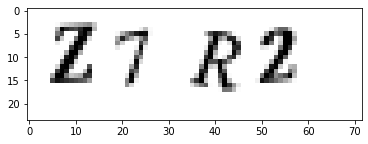

In [34]:
plt.imshow(cv.cvtColor(img_test[2], cv.COLOR_BGR2RGB))

In [35]:
PredictFullCaptcha(img_test[2], 4, logreg, THRESHOLD=180)

['z', '7', 'r', '2']

In [36]:
logreg_full_predictions = []
for img in img_test:
    logreg_full_predictions.append(''.join(PredictFullCaptcha(img, 4, logreg, THRESHOLD=180, APPLY_BLUR=False)))

test_accuracy = accuracy_score(lab_test, logreg_full_predictions)

print(f"Test accuracy score: {test_accuracy}")

Test accuracy score: 0.9669724770642202


**Decision Trees**

In [37]:
n_trees = range(1, 20)

acc_train = []
acc_val = []

for i in n_trees:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    
    acc_train.append(dt.score(X_train, y_train))
    acc_val.append(dt.score(X_val, y_val))

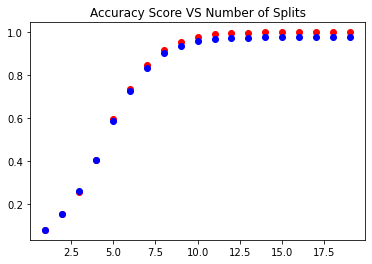

In [38]:
plt.figure()

plt.scatter(x = n_trees, y = acc_train, color = 'r')
plt.scatter(x = n_trees, y = acc_val, color = 'b')

plt.title('Accuracy Score VS Number of Splits')
plt.show()

We get good accuracies after 10 splits.

In [39]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [40]:
val_prediction = dt.predict(X_val)

val_accuracy = accuracy_score(val_prediction, y_val)

print(f"Validation set accuracy score: {val_accuracy}")

Validation set accuracy score: 0.9569398907103825


In [41]:
dt_full_predictions = []
for img in img_test:
    dt_full_predictions.append(''.join(PredictFullCaptcha(img, 4, dt, THRESHOLD=180, APPLY_BLUR=False)))
    
test_accuracy = accuracy_score(lab_test, dt_full_predictions)

print(f"Test accuracy score: {test_accuracy}")

Test accuracy score: 0.8831804281345565


**Random Forest**

In [42]:
estimators = [('model', RandomForestClassifier())]

param_grid = [{'model__n_estimators':range(2, 22, 2)}]

pipe = Pipeline(estimators)
grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X_sample, y_sample)
fittedgrid.best_estimator_

Pipeline(steps=[('model', RandomForestClassifier(n_estimators=18))])

In [43]:
fittedgrid.cv_results_['mean_test_score']

array([0.9692422 , 0.98098122, 0.98399811, 0.98590013, 0.98603117,
       0.986884  , 0.98714627, 0.98675276, 0.98760518, 0.98747405])

In [44]:
rfc_full_predictions = []
for img in img_test:
    rfc_full_predictions.append(''.join(PredictFullCaptcha(img, 4, fittedgrid, THRESHOLD=180, APPLY_BLUR=False)))

In [45]:
test_accuracy = accuracy_score(lab_test, rfc_full_predictions)

print(f"Training set accuracy score: {test_accuracy}")

Training set accuracy score: 0.963914373088685


**Testing on a CAPTCHA that has a noisy background**

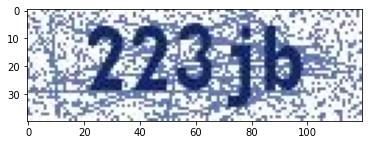

In [46]:
image = library.nfesjppr.images[0]

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [47]:
library_test = library.nfesjppr
threshold = 100
blur = True
dilate = False

X_sample = []
y_sample = []

img_train, img_test, lab_train, lab_test = train_test_split(library_test.images, library_test.targets, test_size = 0.3)

LoadSample(img_train, lab_train, X_sample, y_sample, THRESHOLD = threshold, APPLY_BLUR = blur, APPLY_DILATION = dilate)

if (len(X_sample) == len(y_sample)):
    print(f'We are ready to train the model! There are {len(X_sample)} total samples we can use to train on.')
else:
    print(f'Oops, something muct be wrong: the number of cropped letters does not match the number of labels.')
    print(f'X: {len(X_sample)}, y: {y_sample}')

We are ready to train the model! There are 52475 total samples we can use to train on.


In [48]:
for i in range(len(X_sample)):
    X_sample[i] = Reshape_Transform(X_sample[i], dim = (20, 20))

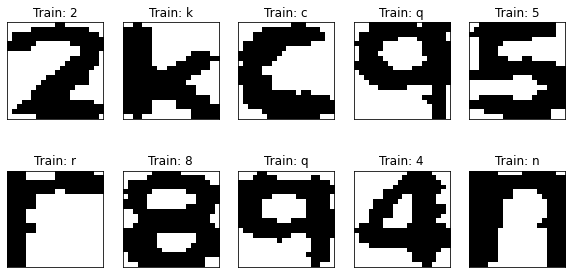

In [49]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))

plot_index = 0

for i in [random.randrange(len(X_sample)) for i in range(10)]:
    plot_index += 1
    plt.subplot(2, 5, plot_index)
    plt.imshow(X_sample[i], cmap="gray_r")
    plt.title(f'Train: {y_sample[i]}')
    
    plt.tick_params(left = False, labelleft = False,
                labelbottom = False, bottom = False)
    
plt.show()

In [50]:
X_sample = np.asarray(X_sample)

X_sample = X_sample.reshape(X_sample.shape[0], X_sample[0].shape[0] * X_sample[0].shape[1])

X_sample = X_sample/255

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size = 0.3, stratify = y_sample)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

C:\Users\alcob\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

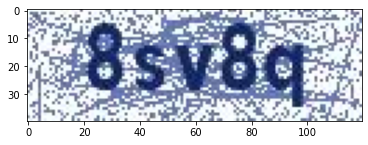

In [52]:
plt.imshow(cv.cvtColor(img_test[0], cv.COLOR_BGR2RGB))

In [53]:
PredictFullCaptcha(img_test[0], 5, logreg, THRESHOLD=100, APPLY_BLUR=True)

['8', 's', 'v', '8', 'q']

In [54]:
logreg_full_predictions = []
for img in img_test:
    logreg_full_predictions.append(''.join(PredictFullCaptcha(img, 5, logreg, THRESHOLD=100, APPLY_BLUR=True)))

test_accuracy = accuracy_score(lab_test, logreg_full_predictions)

print(f"Test accuracy score: {test_accuracy}")

Test accuracy score: 0.9904423205156702


**Testing on Distorted Characters and Colorful Background**

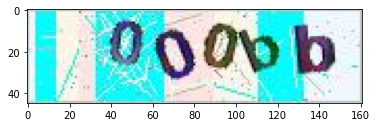

In [64]:
image = library.sefazsp.images[0]

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [82]:
library_test = library.sefazsp
threshold = 140
blur = True
dilate = False

X_sample = []
y_sample = []

X_test = []
y_test = []

img_train, img_test, lab_train, lab_test = train_test_split(library_test.images, library_test.targets, test_size = 0.3)

LoadSample(img_train, lab_train, X_sample, y_sample, THRESHOLD = threshold, APPLY_BLUR = blur, APPLY_DILATION = dilate)

for i in range(len(X_sample)):
    X_sample[i] = Reshape_Transform(X_sample[i], dim = (20, 20))


if (len(X_sample) == len(y_sample)):
    print(f'We are ready to train the model! There are {len(X_sample)} total samples we can use to train on.')
else:
    print(f'Oops, something muct be wrong: the number of cropped letters does not match the number of labels.')
    print(f'X: {len(X_sample)}, y: {y_sample}')

We are ready to train the model! There are 81175 total samples we can use to train on.


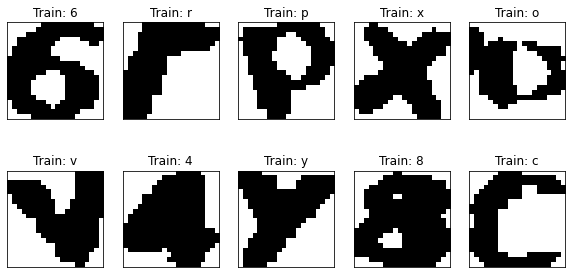

In [83]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))

plot_index = 0

for i in [random.randrange(len(X_sample)) for i in range(10)]:
    plot_index += 1
    plt.subplot(2, 5, plot_index)
    plt.imshow(X_sample[i], cmap="gray_r")
    plt.title(f'Train: {y_sample[i]}')
    
    plt.tick_params(left = False, labelleft = False,
                labelbottom = False, bottom = False)
    
plt.show()

In [84]:
X_sample = np.asarray(X_sample)

X_sample = X_sample.reshape(X_sample.shape[0], X_sample[0].shape[0] * X_sample[0].shape[1])

X_sample = X_sample/255

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size = 0.3, stratify = y_sample)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

C:\Users\alcob\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

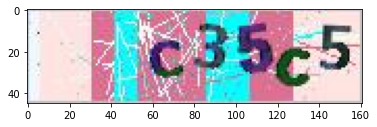

In [86]:
plt.imshow(cv.cvtColor(img_test[0], cv.COLOR_BGR2RGB))

In [87]:
PredictFullCaptcha(img_test[0], 5, logreg, THRESHOLD=140, APPLY_BLUR=True)

['c', '3', 'n', 'e', '5']

In [88]:
logreg_full_predictions = []
for img in img_test:
    logreg_full_predictions.append(''.join(PredictFullCaptcha(img, 5, logreg, THRESHOLD=140, APPLY_BLUR=True)))

test_accuracy = accuracy_score(lab_test, logreg_full_predictions)

print(f"Test accuracy score: {test_accuracy}")

Test accuracy score: 0.716297786720322


Here we start seeing where the models and transformations applied start to struggle.

**Testing On CAPTCHAS that have obstructions between characters**

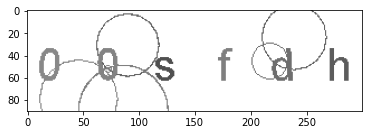

In [89]:
image = library.pje.images[0]

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [90]:
library_test = library.pje
threshold = 180
blur = False
dilate = True

X_sample = []
y_sample = []

img_train, img_test, lab_train, lab_test = train_test_split(library_test.images, library_test.targets, test_size = 0.3)

LoadSample(img_train, lab_train, X_sample, y_sample, THRESHOLD = threshold, APPLY_BLUR = blur, APPLY_DILATION = dilate)

for i in range(len(X_sample)):
    X_sample[i] = Reshape_Transform(X_sample[i], dim = (20, 20))

if (len(X_sample) == len(y_sample)):
    print(f'We are ready to train the model! There are {len(X_sample)} total samples we can use to train on.')
else:
    print(f'Oops, something muct be wrong: the number of cropped letters does not match the number of labels.')
    print(f'X: {len(X_sample)}, y: {y_sample}')

We are ready to train the model! There are 42000 total samples we can use to train on.


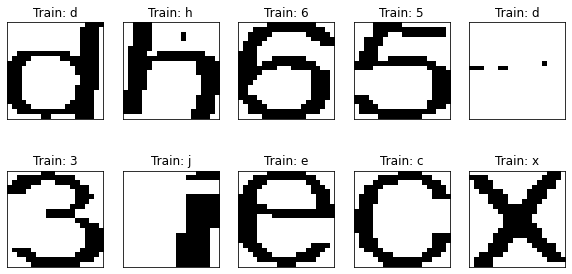

In [91]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))

plot_index = 0

for i in [random.randrange(len(X_sample)) for i in range(10)]:
    plot_index += 1
    plt.subplot(2, 5, plot_index)
    plt.imshow(X_sample[i], cmap="gray_r")
    plt.title(f'Train: {y_sample[i]}')
    
    plt.tick_params(left = False, labelleft = False,
                labelbottom = False, bottom = False)
    
plt.show()

While dilating helps by removing it also adds a new level of complexity where a lot of the actual letters get thinner causing some of them to break. Dilating may also leave some pixels on so they may also get detected when we try to get the contours. We will not train a model on this data as the training set itself will have wrongly labeled shapes.

While it requires a lot more preprocessing we have shown that we can use this method on half of our sample CAPTCHAS. It is by far not perfect but can get the job done and does not require a lot of samples for training, as for any CAPTCHA that we get, we have multiple letters to train on. We can still use some of the cleaning techniques when training Neural Networks, which we will try in the next Notebook.